In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from SaVer_Toolbox import signedDistanceFunction, verify

# Set the seed for reproducibility
torch.manual_seed(128)

In [86]:
betaDKW = 0.001
epsilonDKW = 0.001
Delta = 1-0.999
verifDKW = verify.usingDKW(betaDKW,epsilonDKW,Delta)
betaScenario = 0.001
verifScenario = verify.usingScenario(betaScenario,Delta)


-----------------------------------------------------------------
Error between true and empirical CDF (i.e. \sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon): epsilon = 0.001
Confidence level (i.e. P(\sup_x(|cdfTrue(x) - cdfEmpirical(x)|) < \epsilon) >= 1-\beta): 1-beta = 0.999
Number of samples needed from simulator/sampler: 3800452
Please add the specification by calling "usingDKW.addSpecification()" function.
Then, add samples by calling "usingDKW.addSamples()" function.
-----------------------------------------------------------------
-----------------------------------------------------------------
Confidence level (i.e. P(P(g_C(f(x)) <= 0) >= 1-\Delta) >= 1-\beta): 1-beta = 0.999, 1-Delta = 0.999
Number of samples needed from simulator/sampler: 12510
Please add the specification by calling "usingScenario.addSpecification()" function.
Then, add samples by calling "usingScenario.addSamples()" function.
-----------------------------------------------------------------


In [ ]:
# Define the parameters of the distribution
num_dimensions = 4

# Seed the random number generator for reproducibility
np.random.seed(43)

# Generate samples from a standard Cauchy distribution
samplesDKW = np.random.standard_cauchy((verifDKW.samplesRequired(), num_dimensions))
samplesScenario = np.random.standard_cauchy((verifScenario.samplesRequired(), num_dimensions))


class ReLUFeedforwardNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReLUFeedforwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the dimensions of the network
input_size = num_dimensions
hidden_size = 10
output_size = 2

# Create an instance of the ReLU feedforward network
network = ReLUFeedforwardNetwork(input_size, hidden_size, output_size)
torch.nn.init.xavier_uniform_(network.fc1.weight)
torch.nn.init.xavier_uniform_(network.fc2.weight)

# Convert samples to a PyTorch tensor
samples_tensor_DKW = torch.tensor(samplesDKW, dtype=torch.float32)
samples_tensor_Scenario = torch.tensor(samplesScenario, dtype=torch.float32)

# Evaluate the network using the samples
output_tensor_DKW = network(samples_tensor_DKW)
output_tensor_Scenario = network(samples_tensor_Scenario)

# Convert the output to a numpy array
samplesDKW = output_tensor_DKW.detach().cpu().numpy()
samplesScenario = output_tensor_Scenario.detach().cpu().numpy()

Number of samples needed from simulator/sampler: 3800452
Number of samples needed from simulator/sampler: 12510


In [88]:
# Center of the norm-ball
center = np.array(0.0)
zero_radius_fixed = np.array(20000)
normSDF = signedDistanceFunction.norm(center,zero_radius_fixed,norm=2)

# Add SDF: 
verifDKW.specification(normSDF)
verifScenario.specification(normSDF)

-----------------------------------------------------------------
Specification updated. Please add samples by calling 'usingDKW.addSamples()' function.
----------------------------------------------------------------
-----------------------------------------------------------------
Specification updated. Please add samples by calling 'usingScenario.addSamples()' function.
----------------------------------------------------------------


In [89]:
# Add samples to the verifier
verifDKW.samples(samplesDKW)
verifScenario.samples(samplesScenario)

In [ ]:
# Check if the samples satisfy the specification: 
verifDKW.probability()
verifScenario.probability()

-----------------------------------------------------------------
Specification satisfied with probability: 99.9960531010522% +/- 0.1% which is greater than 0.999
-----------------------------------------------------------------
-----------------------------------------------------------------
Specification satisfied as scaling is -7004.89702968876 which is less than 0
-----------------------------------------------------------------


In [ ]:
# Modify the set:
setReductionDKW = verifDKW.modifySet()
setReductionScenario = verifScenario.modifySet()

-----------------------------------------------------------------
DKW-based scaling factor is modified to -19288.07056439467 from the previous value: 0.0
Please rerun "usingDKW.SpecificationSatisfied()" to check if the specification is satisfied.
-----------------------------------------------------------------
-----------------------------------------------------------------
Scenario-based scaling factor is modified to -7004.89702968876 from the previous value: 0.0
Please rerun "usingScenario.SpecificationSatisfied()" to check if the specification is satisfied.
-----------------------------------------------------------------


In [ ]:
# Check if the samples satisfy the specification: 
verifDKW.probability()
verifScenario.probability()

-----------------------------------------------------------------
Specification satisfied with probability: 99.8999855806625% +/- 0.1% which is greater than 0.999
-----------------------------------------------------------------
-----------------------------------------------------------------
Specification satisfied as scaling is 0.0 which is equal to 0
-----------------------------------------------------------------


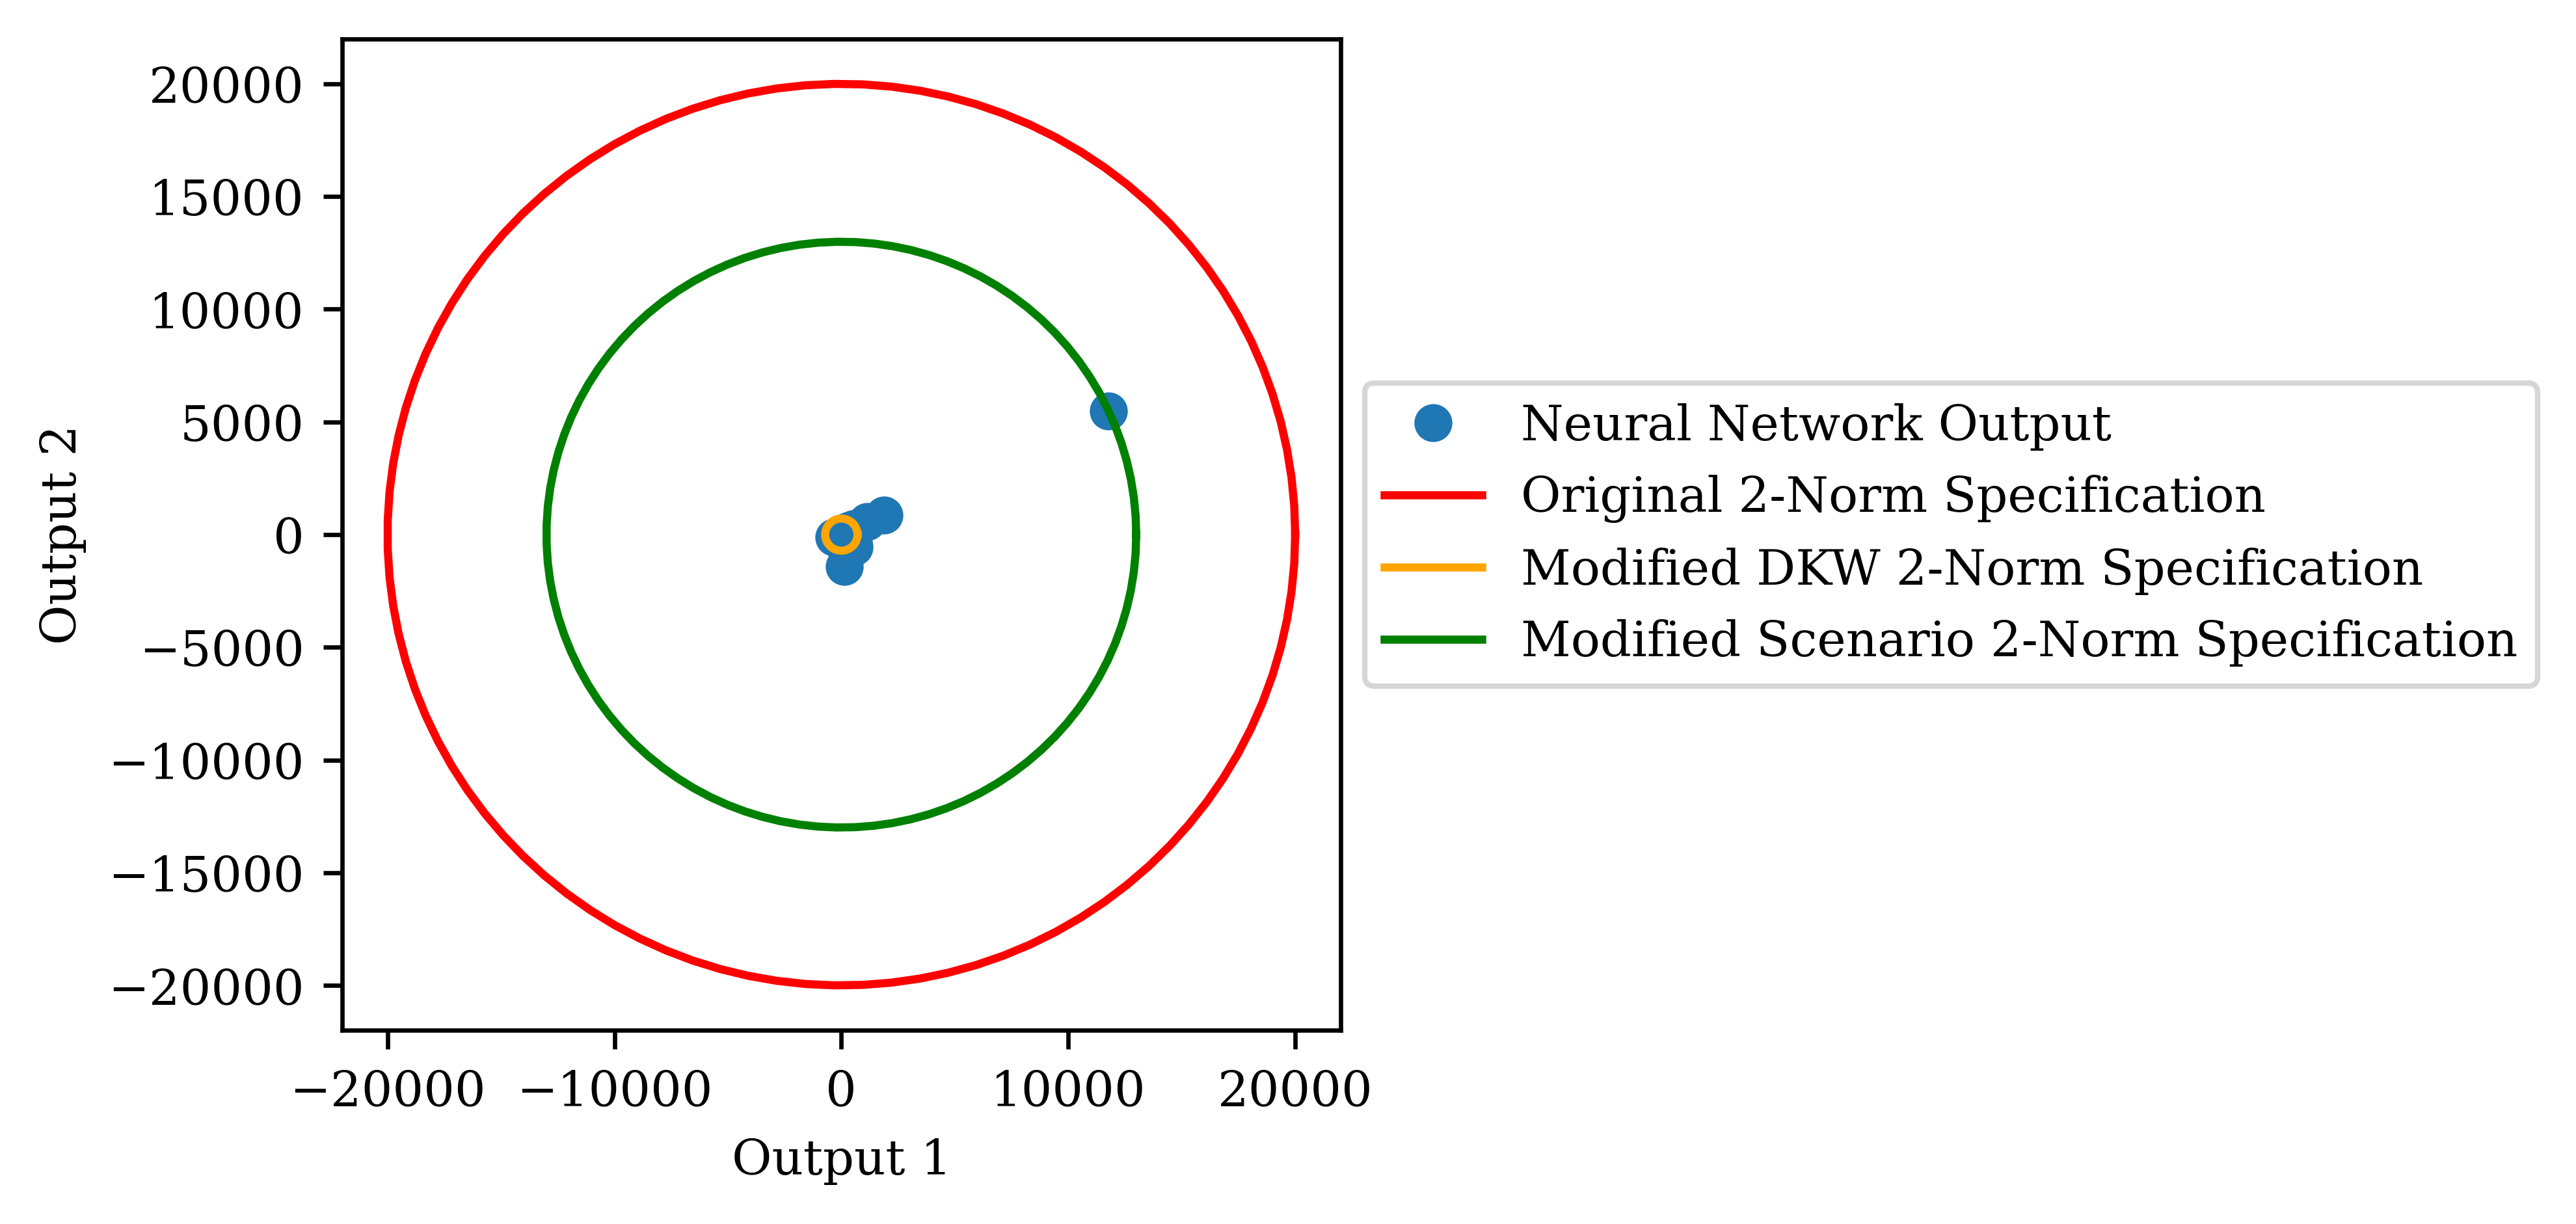

In [ ]:
plt.rcParams.update({'font.size': 9, 'font.family': 'serif'})
plt.figure(figsize=(3.3, 3.3))

# Plot the samples
plt.plot(samplesScenario[:,0],samplesScenario[:,1], 'o', label='Neural Network Output')

# Plot 2-norm ball of a specific radius
theta = np.linspace(0, 2 * np.pi, 100)
x = zero_radius_fixed * np.cos(theta)
y = zero_radius_fixed * np.sin(theta)
plt.plot(x, y, 'r',label='Original 2-Norm Specification')

# Plot 2-norm ball of a specific radius
theta = np.linspace(0, 2 * np.pi, 100)
x = (zero_radius_fixed+setReductionDKW) * np.cos(theta)
y = (zero_radius_fixed+setReductionDKW) * np.sin(theta)
plt.plot(x, y, 'orange',label='Modified DKW 2-Norm Specification')

theta = np.linspace(0, 2 * np.pi, 100)
x = (zero_radius_fixed+setReductionScenario) * np.cos(theta)
y = (zero_radius_fixed+setReductionScenario) * np.sin(theta)
plt.plot(x, y, 'green',label='Modified Scenario 2-Norm Specification')


# Add labels and legend:
plt.xlabel('Output 1')
plt.ylabel('Output 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
# Save and show the plot
print('Saving plot...')
plt.savefig('./Figure5.png', bbox_inches='tight',format='png', dpi=600)
plt.show()